# Spatial Autocorrelation of Transit Equity Areas in Los Angeles - Andrew & Aziz
This notebook uses spatial autocorrelation statistical methods to analyze transit equity in Los Angeles County. LA Metro has a Transit Equity Score (TES) that indicates where transit is of most need based on key socioeconomic indicators within
Los Angeles County. TES consists of seven measures: Zero Car Households per Acre, Poverty/Low Income Households per Acre, School Age Students (age 10-19) per Acre, Seniors over 55 as of 2010 per Acre, Single Mothers per Acre, Disabled Persons per Acre, Minorities per Acre. These scores for each census tract are added up and divided by 7 - with Zero Car Households and Minorities given greater weight. Census tracts with a score above 3 should be prioritized for transit equity. Further details on the TES are located here: https://media.metro.net/projects_studies/nextgen/images/transit-equity-evaluation-methodology.pdf

For our final project, we plan to calculate our own index scores to rate areas of high transit propensity and need, and evaluate BRT projects using those scores. Our index will incorporate similar measures to LA Metro's TES or Nelson\Nygaard's adjusted population density measure, which accounts for race/ethnicity, vehicle ownership, country of origin, and household income (see below for an example).

![Population Density](https://umjp9n8g2j2ft5j5637up17u-wpengine.netdna-ssl.com/wp-content/uploads/2021/02/TC-2018-Population-Density-01-optimized-768x994.png)
![Adjusted Population Density](https://umjp9n8g2j2ft5j5637up17u-wpengine.netdna-ssl.com/wp-content/uploads/2021/02/TC-2018-Adjusted-Pop-Density-01-optimized-768x994.png)
Source: https://nelsonnygaard.com/transit-equity-is-not-only-about-which-communities-transit-serves-its-also-about-when/

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Import social equity dataset and perform initial explorations
This data comes from https://www.metro.net/projects/netgen/nextgen-data-and-analysis/ (site under maintenance as of March 7) and includes census tracts in LA County with a TES score of 3 or higher.

In [2]:
Social_Equity = gpd.read_file('data/social_equity_communities_3plus_scores.geojson')

In [3]:
Social_Equity = Social_Equity[['PROPEN3_GE','GEOID10','TD_SC_UR','geometry']]

#rename
Social_Equity.columns = ['PROPEN3_GE','FIPS','Transit_Equity_Score','geometry']

In [4]:
Social_Equity = Social_Equity.to_crs(epsg=3857)

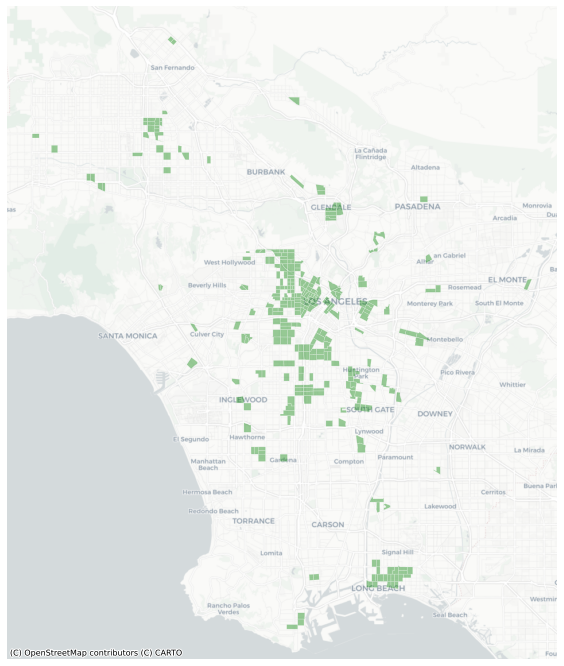

In [5]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

Social_Equity.plot(ax=ax,
         color='green', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

There are areas of high transit equity needs throughout the county, including much of Central LA and large pockets in the Valley, South LA, Glendale, and Long Beach.

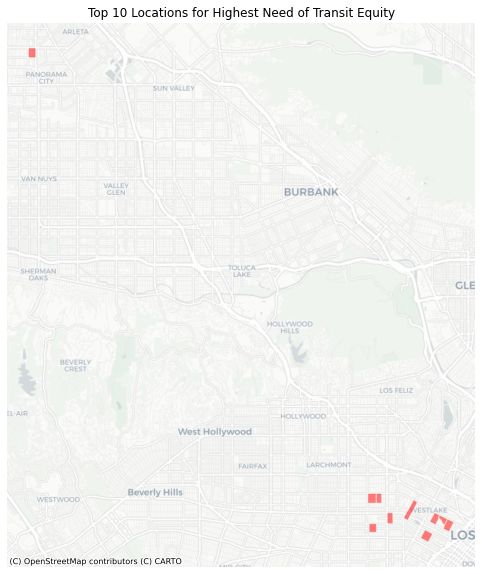

In [6]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
Social_Equity.sort_values(by='Transit_Equity_Score',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top 10 Locations for Highest Need of Transit Equity')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The 10 tracts with the highest TES scores are all located around Westlake/Koreatown, with one tract in near Panorama City.

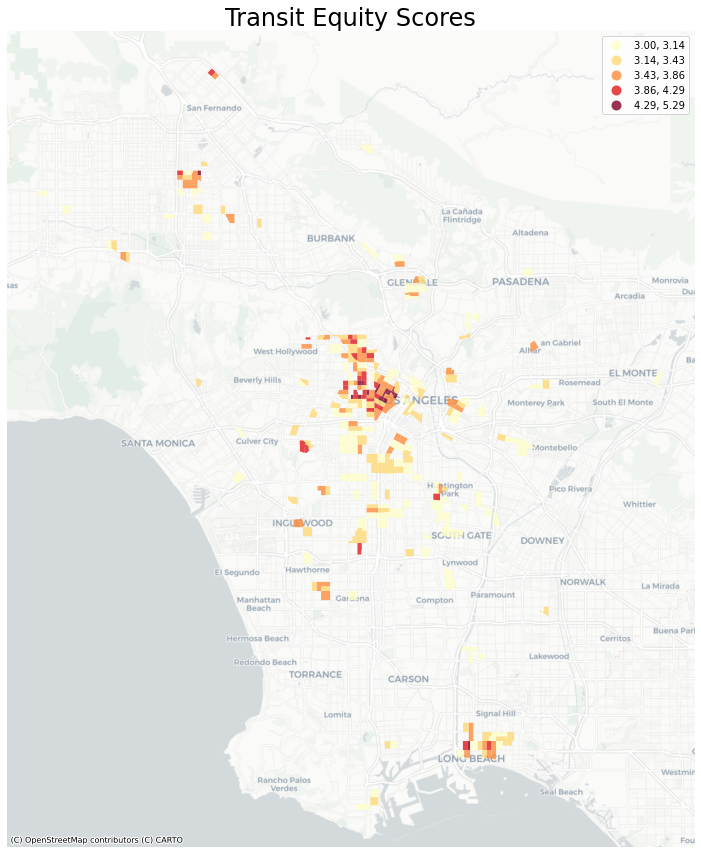

In [7]:
fig,ax = plt.subplots(figsize=(15,15))

Social_Equity.plot(ax=ax,
        column='Transit_Equity_Score',
        legend=True,
        alpha=0.8,
        k=5,
        cmap='YlOrRd',
        scheme='NaturalBreaks')

ax.axis('off')
ax.set_title('Transit Equity Scores',fontsize=24)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Spatial Autocorrelation Analysis Using the ESDA Library
Transforming the social equity data to conduct the statistical analysis will require several steps, detailed below.

### Global Autocorrelation
* Calculate spatial weight and spatial lag
* Find the dataset's donut and diamond: the donut is a tract with a lowest score in reltion to its neighbors, and the diamond is the tract with the highest score in relation to its neighbors
* Plot the entire dataset based on spatial lag values
* Test for global autocorrelation using Moran's I

In [8]:
#Generate spatial weights using the KNN method and 8 nearest neighbors (k=8)
wq =  lps.weights.KNN.from_dataframe(Social_Equity,k=8)

wq.transform = 'r'

In [9]:
#Create new column of spatial lag, which factors in the TES of neighboring tracts as defined by the spatial weight method above
Social_Equity['Transit_Equity_lag'] = lps.weights.lag_spatial(wq, Social_Equity['Transit_Equity_Score'])

In [10]:
Social_Equity.sample(10)[['Transit_Equity_Score','Transit_Equity_lag']]

Transit_Equity_Score  Transit_Equity_lag
174              3.142857            3.303571
206              3.428571            3.089286
173              3.142857            3.285714
114              4.142857            3.732143
2                4.142857            3.696429
297              3.571429            3.446428
163              3.571429            3.357143
141              3.285714            3.535714
245              3.000000            3.107143
261              3.000000            3.232143

In [11]:
Social_Equity['Transit_Equity_diff'] = Social_Equity['Transit_Equity_Score'] - Social_Equity['Transit_Equity_lag']

In [12]:
token = 'pk.eyJ1IjoiYWZlbGxhZ3VlIiwiYSI6ImNrbHh6eW93cTA0OHEydm82dTN1eDc3dDUifQ.vjFZ7APPuyFsIGn55kqpaw'
px.set_mapbox_access_token(token)

In [13]:
Social_Equity_donut = Social_Equity.sort_values(by='Transit_Equity_diff').head(1)
Social_Equity_donut

PROPEN3_GE         FIPS  Transit_Equity_Score  \
121  06037212101  06037212101              3.285714   

                                              geometry  Transit_Equity_lag  \
121  POLYGON ((-13168720.948 4037149.637, -13168721...            4.267857   

     Transit_Equity_diff  
121            -0.982143

This tract has an unusually low TES (meaning lower equity needs) as compared to its neighbors.

In [14]:
Social_Equity_diamond = Social_Equity.sort_values(by='Transit_Equity_diff').tail(1)
Social_Equity_diamond

PROPEN3_GE         FIPS  Transit_Equity_Score  \
102  06037209403  06037209403              5.285714   

                                              geometry  Transit_Equity_lag  \
102  POLYGON ((-13165997.517 4035830.430, -13166106...            3.821429   

     Transit_Equity_diff  
102             1.464285

This tract has an unusually high TES (higher equity needs) relative to neighbors, indicating a possible transit desert.

In [15]:
Social_Equity_donut = Social_Equity_donut.to_crs('epsg:4326')
minx, miny, maxx, maxy = Social_Equity_donut.geometry.total_bounds
center_lat_donut = (maxy-miny)/2+miny
center_lon_donut = (maxx-minx)/2+minx

In [16]:
Social_Equity_diamond = Social_Equity_diamond.to_crs('epsg:4326')

minx, miny, maxx, maxy = Social_Equity_diamond.geometry.total_bounds
center_lat_diamond = (maxy-miny)/2+miny
center_lon_diamond = (maxx-minx)/2+minx

In [17]:
px.choropleth_mapbox(Social_Equity_donut, 
                     geojson=Social_Equity_donut.geometry, 
                     locations=Social_Equity_donut.index, 
                     mapbox_style="satellite-streets",
                     zoom=14, 
                     center = {"lat": center_lat_donut, "lon": center_lon_donut},
                     hover_data=['Transit_Equity_Score','Transit_Equity_lag'],
                     opacity=0.4,
                     title='The Donut')

In [18]:
px.choropleth_mapbox(Social_Equity_diamond, 
                     geojson=Social_Equity_diamond.geometry, 
                     locations=Social_Equity_diamond.index, 
                     mapbox_style="satellite-streets",
                     zoom=12, 
                     center = {"lat": center_lat_diamond, "lon": center_lon_diamond},
                     hover_data=['Transit_Equity_Score','Transit_Equity_lag'],
                     opacity=0.4,
                     title='The Diamond')

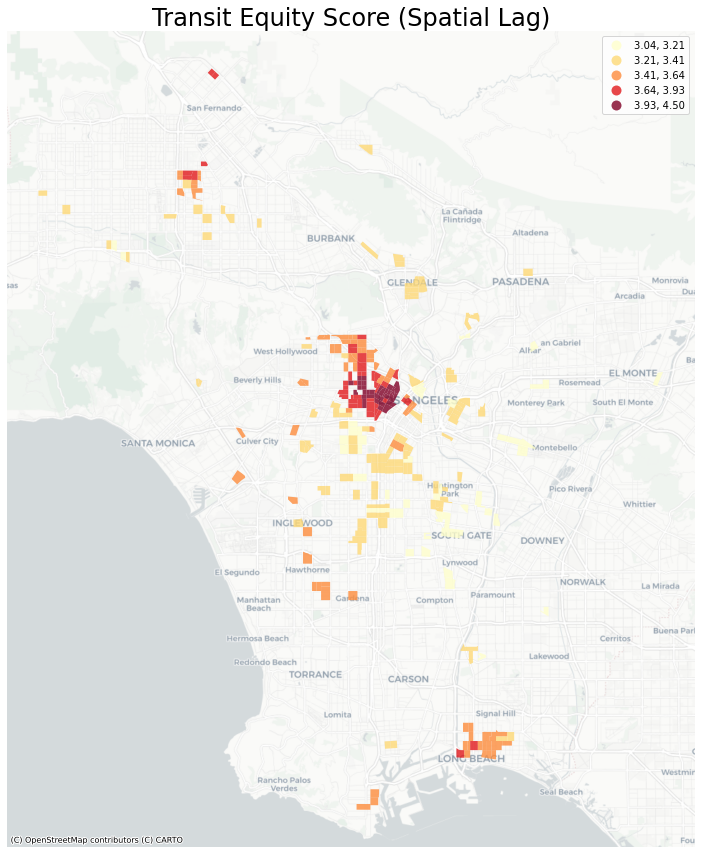

In [19]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
Social_Equity.plot(ax=ax,
         figsize=(15,15),
         column='Transit_Equity_lag',
         legend=True,
         k=5,
         alpha=0.8,
         cmap='YlOrRd',
         scheme='NaturalBreaks')

ax.axis('off')
ax.set_title('Transit Equity Score (Spatial Lag)',fontsize=24)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

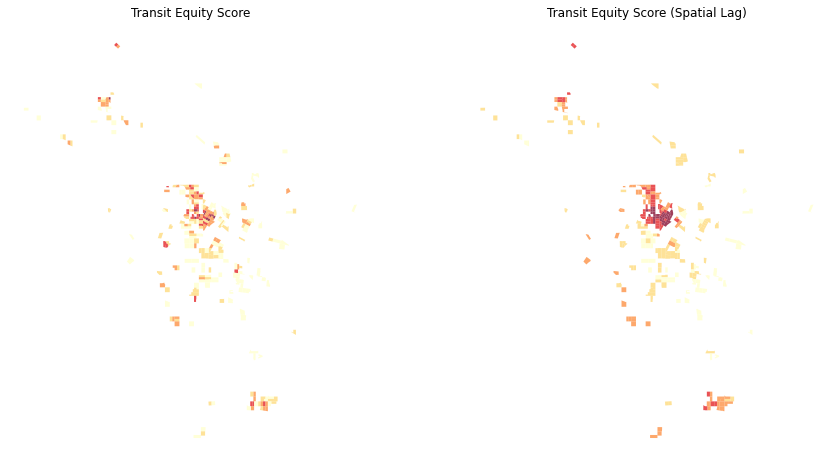

In [20]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
Social_Equity.plot(ax=ax[0], # this assigns the map to the left subplot
         column='Transit_Equity_Score', 
         cmap='YlOrRd', 
         scheme='NaturalBreaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Transit Equity Score")

# spatial lag map on the right
Social_Equity.plot(ax=ax[1], # this assigns the map to the right subplot
         column='Transit_Equity_lag', 
         cmap='YlOrRd', 
         scheme='NaturalBreaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Transit Equity Score (Spatial Lag)")

plt.show()

Below we'll calculate the degree of spatial correlations via global autocorrelation of TES.

In [21]:
y = Social_Equity.Transit_Equity_Score
moran = Moran(y, wq)
moran.I

0.3516412362888795

The above value (0.3516412362888795) is the slope of the scatterplot of the TES spatial lag column, plotted below.

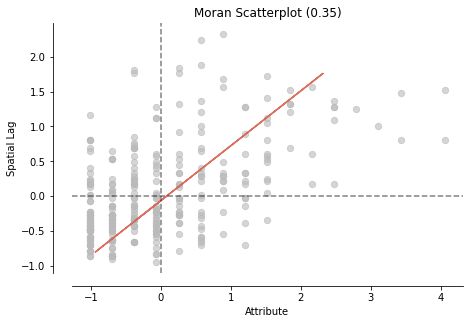

In [22]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning:


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning:


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.



(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1ad5918e0>)

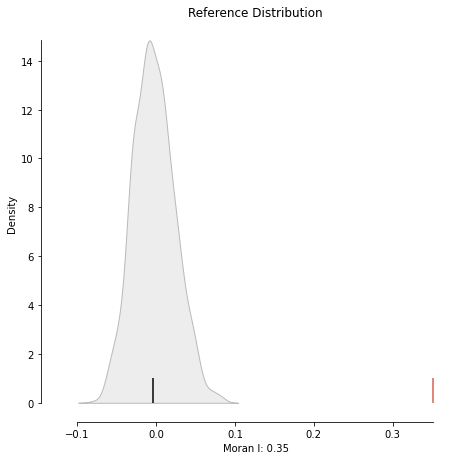

In [23]:
plot_moran_simulation(moran,aspect_equal=False)

In [24]:
moran.p_sim

0.001

Our p-value of .001 allows us to reject the null hypothesis of a random distribution of values in the map, and provides statistical evidence that a spatial pattern exists in our dataset. To get more detailed information about these spatial patterns, we'll use the LISA method.

### Local Spatial Autocorrelation
A calculation of Local Indicators of Spatial Association (LISA) will sort high (H) and low (L) spatial correlation values into HH, LL HL, and LH groups. The HL group is tracts with a high TES score surrounded by neighbors with a low score (diamonds), while the LH group is tracts with a low TES score surrounded by neighbors with a high TES score (donuts).

In [25]:
lisa = esda.moran.Moran_Local(y, wq)

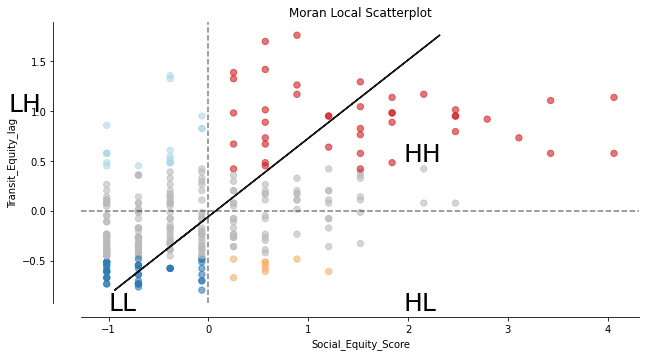

In [26]:
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Social_Equity_Score")
ax.set_ylabel('Transit_Equity_lag')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

The values plotted here are all statistically significant, and we are particulary interested in the HL and LH values. To see where these tracts are located, we'll plot the results of our LISA analysis.

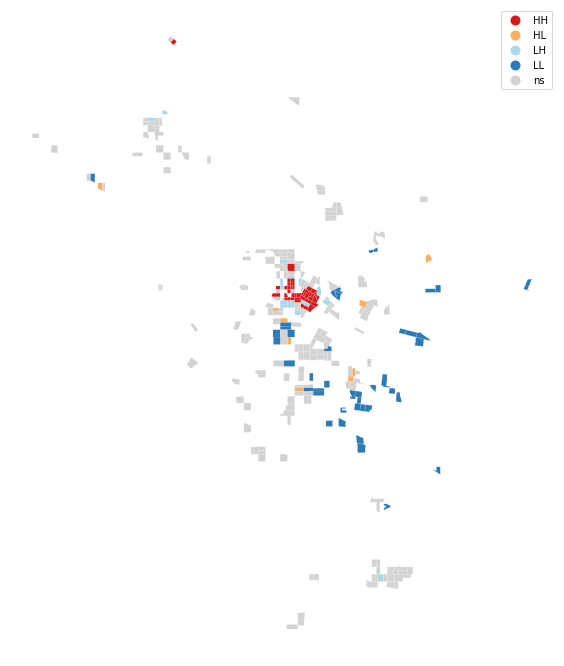

In [27]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, Social_Equity, p=0.05, ax=ax)
plt.show()

The values are spread all over, but there is a grouping of LH tracts in the DTLA to Koreatown area. 

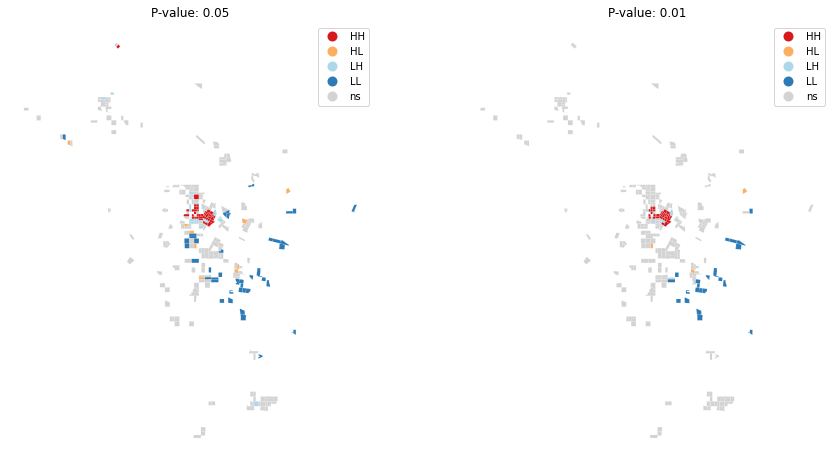

In [28]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# regular count map on the left
lisa_cluster(lisa, Social_Equity, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, Social_Equity, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

We do lose some tracts between a p-value of .05 and .01 but a good part of the LH cluster remains statistically significant.

### Results of spatial autocorrelation analysis and application
Our analysis showed that the distribution of TES spatial lag is not random for the datasest, and further identified the locations of high-low (HL) and low-high (LH) tracts - tracts with a high TES whose neighbors have low TES, or the opposite.

We hope to incorporate a spatial autocorrelation analysis into our own transit equity/propensity index, time permitting. This will give us some insights into neighborhoods of interest for transit service provision.

## Credits
Aziz found the dataset used for this week and wrote/troubleshooted the spatial autocorrelation code. Andrew added markdown cells to explain the steps.